In [1]:
import sys
import os
sys.path.append(os.path.expanduser('~/myPy/VEBTF'))
sys.path.append(os.path.expanduser('~/myPy/VEBTF/src'))
sys.path.append(os.path.expanduser('~/myPy/VEBTF/VEBTF-paper'))
from matplotlib import pyplot as plt
from src.vebtf import VEBTF
import seaborn as sns
import numpy as np
from skimage.restoration import denoise_wavelet, estimate_sigma
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from methods.methods import *
import matplotlib.pyplot as plt
import yfinance as yf
import timeit

In [2]:
import pandas as pd
df = pd.read_csv(os.path.expanduser("~/myPy/VEBTF/VEBTF-paper/realdata/dataset/all_six_datasets/weather/weather.csv"))
df.head()

,date,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m�),PAR (�mol/m�/s),max. PAR (�mol/m�/s),Tlog (degC),OT
0,2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,...,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45,428.1
1,2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,...,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51,428.0
2,2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,...,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60,427.6
3,2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,...,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70,430.0
4,2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,...,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81,432.2


In [3]:
df.shape

(52696, 22)

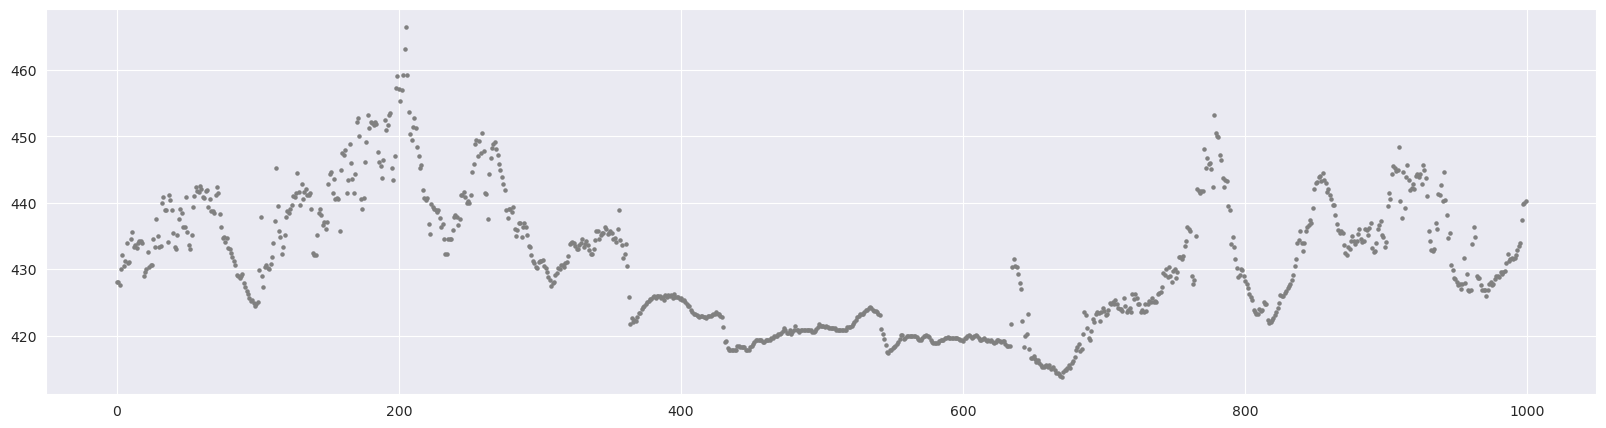

In [8]:
y = df['OT'].values
y = y.squeeze()
y = np.array(y,dtype=float)
n = len(y)
idx = np.arange(0,1000)
plt.figure(figsize=(20, 5))
plt.scatter(idx,y[idx],color='grey',s=5)
plt.show()

In [9]:
y = y[idx]
n = len(y)

In [10]:
susie20 = susie_tf(L=20)
susie20.fit(y)

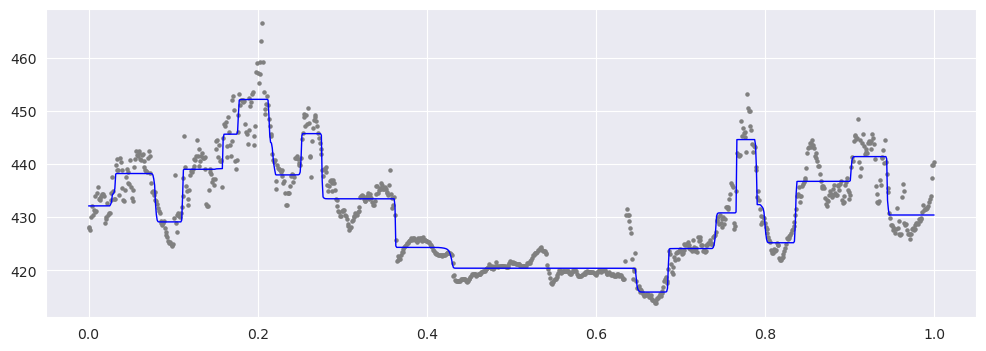

In [11]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 4))
plt.scatter(np.linspace(0,1,len(y)),y,color='grey',s=5)
plt.plot(np.linspace(0,1,len(y)),susie20.mu, color='blue',linewidth = 1)
plt.show()

In [12]:
susie500 = susie_tf(L=500)
susie500.fit(y)

In [6]:
# save susie100 as pickle
import pickle
# with open('results/susie500_weather.pkl', 'wb') as f:
#     pickle.dump(susie500, f)

# load susie100 from pickle
with open('results/susie500_weather.pkl', 'rb') as f:
    susie500 = pickle.load(f)

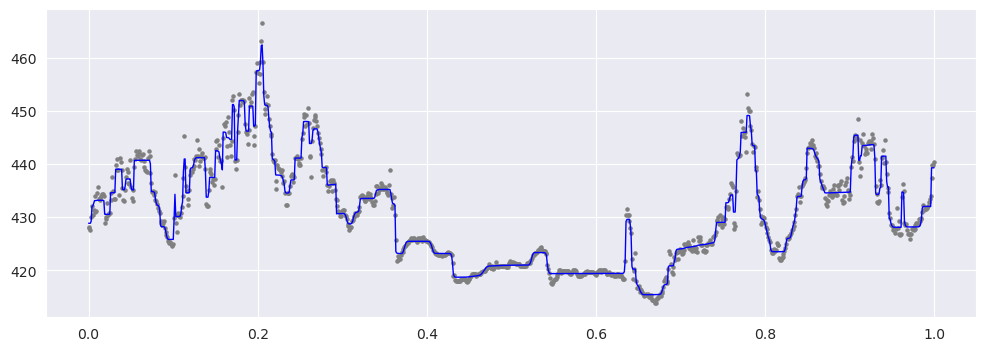

In [10]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 4))
plt.scatter(np.linspace(0,1,len(y)),y,color='grey',s=5)
plt.plot(np.linspace(0,1,len(y)),susie500.mu, color='blue',linewidth = 1)
plt.show()

In [12]:
n = len(y)
genlasso = genlasso_tf(ord=0)
genlasso.fit(y)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 


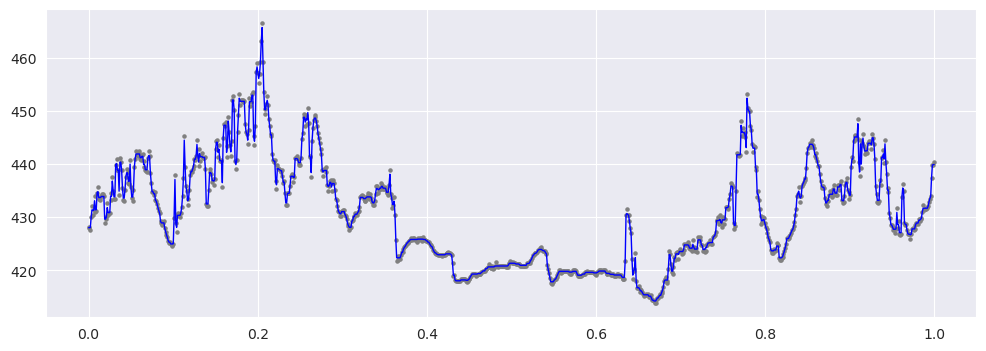

In [13]:

sns.set_style('darkgrid')
plt.figure(figsize=(12, 4))
plt.scatter(np.linspace(0,1,len(y)),y,color='grey',s=5)
plt.plot(np.linspace(0,1,len(y)),genlasso.mu, color='blue',linewidth = 1)
plt.show()

In [14]:
wave = wavelet_denoise(wavelet='haar', num_shifts=n)
wave.fit(y)

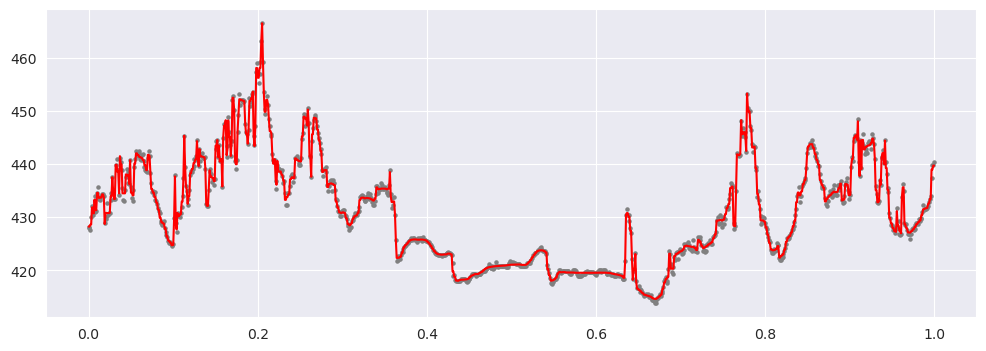

In [15]:
plt.figure(figsize=(12, 4))
plt.scatter(np.linspace(0,1,len(y)),y,color='grey',s=5)
plt.plot(np.linspace(0,1,len(y)),wave.mu, color='red')
plt.show()

In [16]:
model = VEBTF(sigma2=1,printevery=100,prior="ash_update",tol=1e-5,point_mass_sd=np.sqrt(1/n)/2,maxiter=1000)
model.fit(y,mu_init = wave.mu)  

Iteration 0: ELBO = -4075.4619997498544


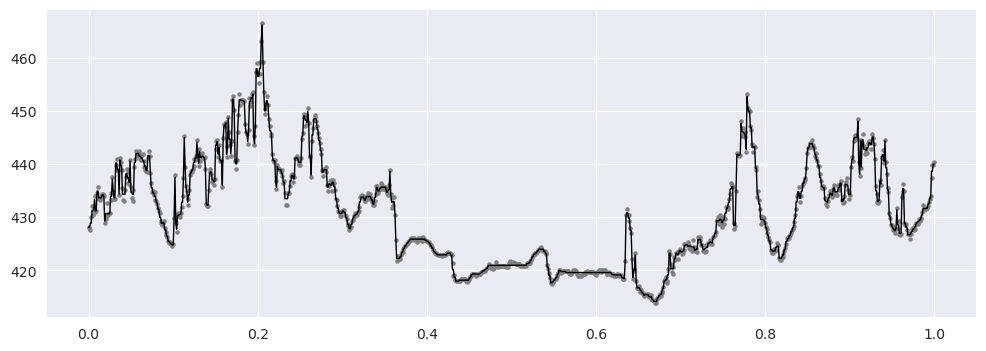

In [17]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 4))
plt.scatter(np.linspace(0,1,len(y)),y,color='grey',s=5)
plt.plot(np.linspace(0,1,len(y)),model.mu, color='black',linewidth=1)
plt.show()

In [18]:
gp = GP_sklearn(kernel='Matern32')
gp.fit(y)
print(gp.fitted_model.kernel_)

0.852**2 * Matern(length_scale=7.44, nu=1.5) + WhiteKernel(noise_level=0.00924)


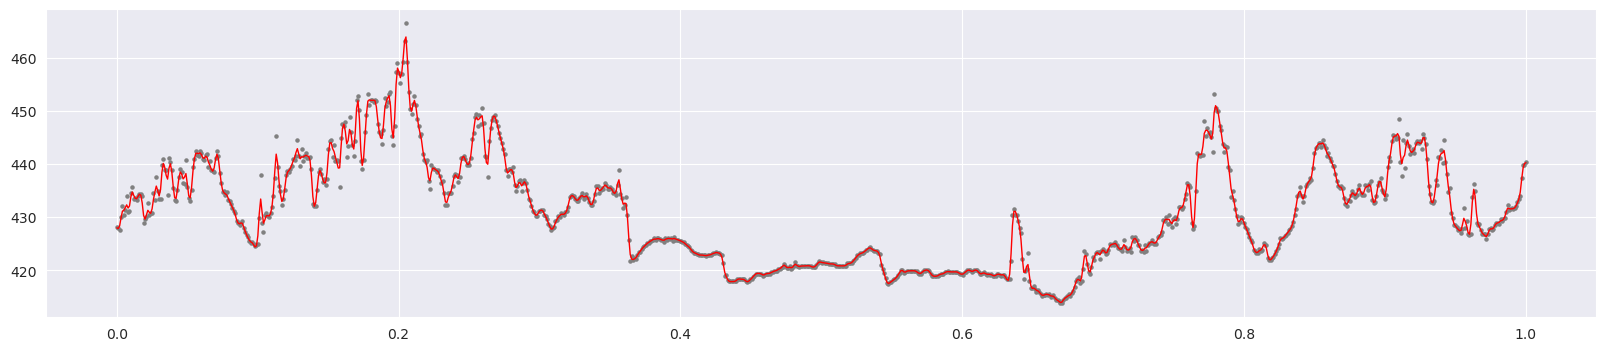

In [19]:
plt.figure(figsize=(20, 4))
plt.scatter(np.linspace(0,1,len(y)),y,color='grey',s=5)
plt.plot(np.linspace(0,1,len(y)),gp.mu, color='red',linewidth=1)
plt.show()

In [ ]:
# df = df.rename(columns={'OT': 'target'})
# df.to_csv("/home/dxie/myPy/VEBTF/VEBTF-paper/realdata/dataset/benchmark/weather.csv", index=False)

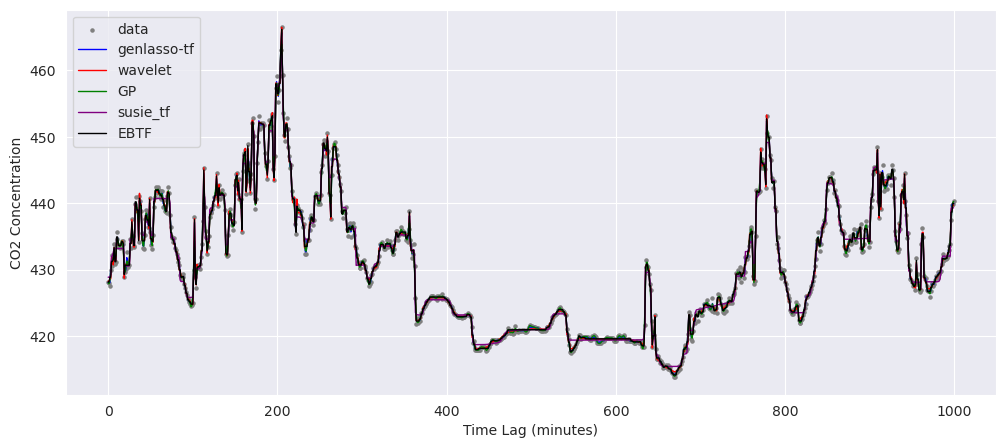

In [27]:
plt.figure(figsize=(12, 5))
idx = np.arange(0,n)
plot_n = len(idx)
plt.scatter(idx,y[idx],color='grey',s=5)

plt.plot(idx,genlasso.mu[idx], color='blue',linewidth = 1)
plt.plot(idx,wave.mu[idx], color='red',linewidth = 1)
plt.plot(idx,gp.mu[idx], color='green',linewidth = 1)
plt.plot(idx,susie500.mu[idx], color='purple',linewidth = 1)
plt.plot(idx,model.mu[idx], color='black',linewidth = 1)


plt.legend(['data', 'genlasso-tf', 'wavelet', 'GP', 'susie_tf', 'EBTF'], 
           loc='upper left', fontsize=10, frameon=True)
plt.xlabel("Time Lag (minutes)")
plt.ylabel("CO2 Concentration")
plt.savefig('results/weather.pdf', bbox_inches='tight')
plt.show()

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Iteration 0: ELBO = -3106.8252680542096


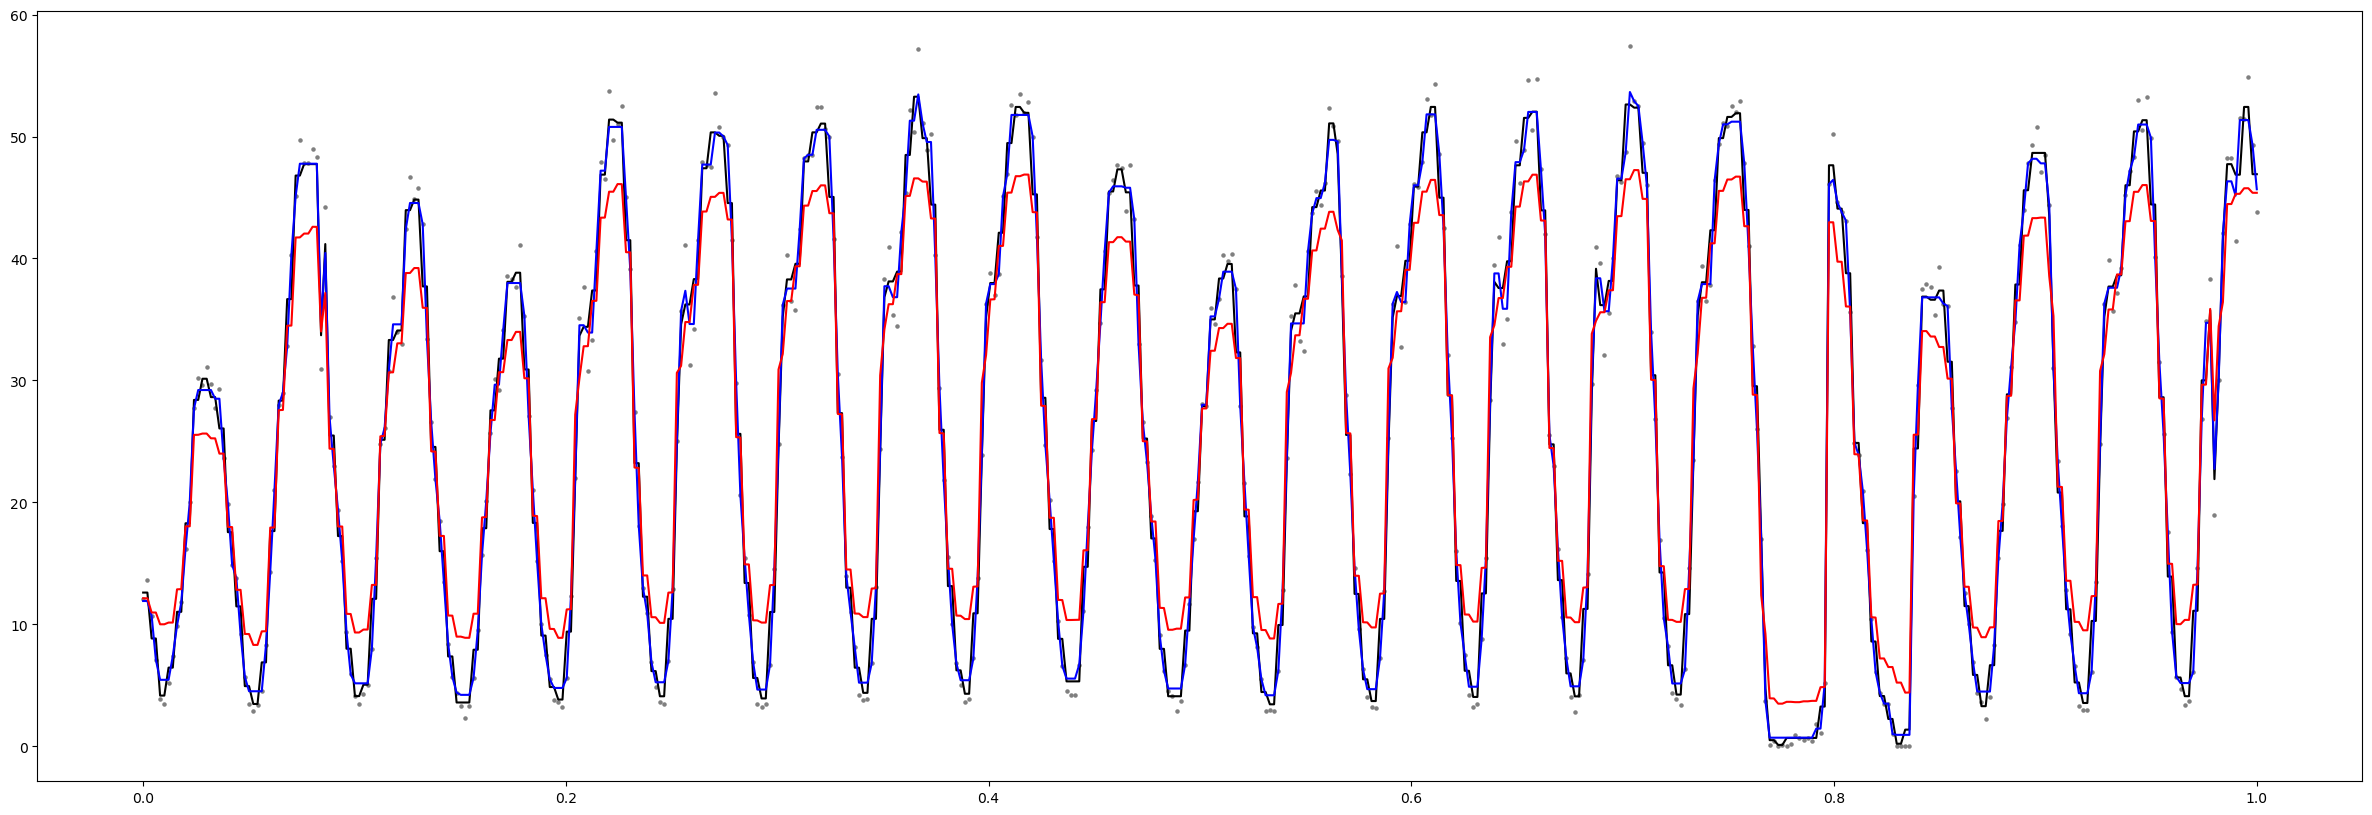

In [140]:
y = y[0:500]
n = len(y)
y = np.array(y,dtype=float)*1000
genlasso = genlasso_tf(ord=0,k=5)
genlasso.fit(y)
model = VEBTF(sigma2=1,printevery=100,prior="ash_update",tol=1e-5,point_mass_sd=np.sqrt(1/n)/2,maxiter=1000,num_shift_wavelet=n,method_wavelet='VisuShrink')
model.fit(y,mu_init = 'wavelet')    
wave = wavelet_denoise(wavelet='haar', num_shifts=n)
wave.fit(y)
plt.figure(figsize=(30, 10))
plt.scatter(np.linspace(0,1,len(y)),y,color='grey',s=5)
plt.plot(np.linspace(0,1,len(y)),model.mu, color='black')
plt.plot(np.linspace(0,1,len(y)),genlasso.mu, color='blue')
plt.plot(np.linspace(0,1,len(y)),wave.mu, color='red')
plt.show()

In [118]:
print(model.pi)
print(model.sk2)

[5.80771972e-01 1.27171858e-02 8.65715503e-03 5.63913342e-03
 3.57111704e-03 2.21921812e-03 1.36125652e-03 8.27355708e-04
 4.99528335e-04 3.00060196e-04 1.79409484e-04 1.06666952e-04
 6.28434804e-05 3.64276680e-05 2.05327107e-05 1.10554163e-05
 5.48714777e-06 2.21800767e-06 2.95627110e-07 3.19417380e-10
 4.52671432e-10 5.53218128e-10 6.21376244e-10 6.70796881e-10
 8.43948000e-10 1.29663252e-09 1.66604535e-09 1.85148565e-09
 1.87552348e-09 1.79904706e-09 1.67484294e-09 1.53336455e-09
 1.39517631e-09 1.27492699e-09 1.17620221e-09 1.09977918e-09
 1.04064501e-09 9.91943590e-10 9.52036681e-10 9.19504298e-10
 8.92812557e-10 8.74104536e-10 8.59234119e-10 8.46755492e-10
 8.34772716e-10 8.24096192e-10 8.12861849e-10 8.01479809e-10
 7.92761178e-10 7.92761178e-10 7.92761178e-10 7.92761178e-10
 7.92761178e-10 3.32938122e-09 2.06373967e-06 4.99534494e-05
 2.85410953e-04 8.34564749e-04 1.39126354e-03 1.58705467e-03
 1.55836973e-03 1.57234277e-03 1.88214213e-03 2.82440672e-03
 4.90410642e-03 7.880687

In [107]:
model.sigma2

3367557.0379062244